<a href="https://colab.research.google.com/github/rrfsantos/Projeto-Localizacao-e-Uso-da-Informacao--IMDB/blob/main/trabalhoLUI_IMDB_Codigo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lxml
!pip install bs4

Requirement already satisfied: lxml in /databricks/python3/lib/python3.7/site-packages (4.6.2)
 WARNING: You are using pip version 20.0.2; however, version 21.0.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python3.7 -m pip install --upgrade pip' command. 
Requirement already satisfied: bs4 in /databricks/python3/lib/python3.7/site-packages (0.0.1)
Requirement already satisfied: beautifulsoup4 in /databricks/python3/lib/python3.7/site-packages (from bs4) (4.9.3)
Requirement already satisfied: soupsieve>1.2; python_version >= "3.0" in /databricks/python3/lib/python3.7/site-packages (from beautifulsoup4->bs4) (2.2)
 WARNING: You are using pip version 20.0.2; however, version 21.0.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python3.7 -m pip install --upgrade pip' command.

In [ ]:
import lxml
import re
import numpy as np
import pandas as pd
import requests
import string
import seaborn as sns
import matplotlib.pyplot as plt
import typing

from bs4 import BeautifulSoup

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"}

url1 = 'https://www.imdb.com/search/title?count=100&title_type=feature,tv_series&ref_=nv_wl_img_2'

## 1 - Encontrar o padrão da URL

In [ ]:
response = requests.get(url1, headers=headers)
soup = BeautifulSoup(response.text,'html.parser')

In [ ]:
movies = soup.find('div', attrs={'class': 'desc'}).get_text() # <----- Busca o número total de filmes (imagem 1)

In [ ]:
punc_re = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', str(x).lower())
movies = punc_re(movies)
movies = [float(s) for s in re.findall(r'-?\d+\.?\d*', movies)]
movies = int(movies[1])

In [ ]:
print('Número total de filmes: ', movies)

Número total de filmes: 656258

In [ ]:
url_list = [url1] # <---- url1 não segue o padrão das páginas seguintes
start = 1
for i in range(0,movies,100):       ### --->>> Cada página contém 100 filmes <<<---
    start +=100
    url_list.append('https://www.imdb.com/search/title/?title_type=feature,tv_series&count=100&start='+str(start)+'&ref_=adv_nxt')
print(url_list[3])

https://www.imdb.com/search/title/?title_type=feature,tv_series&count=100&start=301&ref_=adv_nxt

## 2 - Executar webscraping do número de páginas (n) desejado e criar dataframe com as informações

In [ ]:
### Definir número de páginas ###
n = 100

In [ ]:
### Função para executar webscraping ###
class IMDB(object):
	"""docstring for IMDB"""
	def __init__(self, url):
		super(IMDB, self).__init__()
		page = requests.get(url)

		self.soup = BeautifulSoup(page.content, 'lxml')

	def articleTitle(self):
		return self.soup.find("h1", class_="header").text.replace("\n","")

	def bodyContent(self):
		content = self.soup.find(id="main")
		return content.find_all("div", class_="lister-item mode-advanced")

	def movieData(self):
		movieFrame = self.bodyContent()
		movieTitle = []
		movieDate = []
		movieRunTime = []
		movieGenre = []
		movieRating = []
		movieScore = []
		movieDescription = []
		movieDirector = []
		movieStars = []
		movieVotes = []
		movieGross = []
		for movie in movieFrame:
			
			movieFirstLine = movie.find("h3", class_="lister-item-header")
			
			movieTitle.append(movieFirstLine.find("a").text)
			
			movieDate.append(re.sub(r"[()]","", movieFirstLine.find_all("span")[-1].text))

			try:
				movieRunTime.append(movie.find("span", class_="runtime").text[:-4])
			except:
				movieRunTime.append(np.nan)

			try:
				movieGenre.append(movie.find("span", class_="genre").text.rstrip().replace("\n","").split(","))
			except:
				movieGenre.append(np.nan)

			try:
				movieRating.append(movie.find("strong").text)
			except:
				movieRating.append(np.nan)
			
			try:
				movieScore.append(movie.find("span", class_="metascore unfavorable").text.rstrip())
			except:
				movieScore.append(np.nan)
			
			movieDescription.append(movie.find_all("p", class_="text-muted")[-1].text.lstrip())
			
			movieCast = movie.find("p", class_="")
			try:
				casts = movieCast.text.replace("\n","").split('|')
				casts = [x.strip() for x in casts]
				casts = [casts[i].replace(j, "") for i,j in enumerate(["Director:", "Stars:"])]
				movieDirector.append(casts[0])
				movieStars.append([x.strip() for x in casts[1].split(",")])
			except:
				casts = movieCast.text.replace("\n","").strip()
				movieDirector.append(np.nan)
				movieStars.append([x.strip() for x in casts.split(",")])

			movieNumbers = movie.find_all("span", attrs={"name": "nv"})

			if len(movieNumbers) == 2:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(movieNumbers[1].text)
			elif len(movieNumbers) == 1:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(np.nan)
			else:
				movieVotes.append(np.nan)
				movieGross.append(np.nan)

		movieData = [movieTitle, movieDate, movieRunTime, movieGenre, movieRating, movieScore, movieDescription, movieDirector, movieStars,movieVotes, movieGross]
		return movieData

In [ ]:
if __name__ == '__main__':
	movies_df = pd.DataFrame()
	for i in range(n):  # <------ Número de páginas (n)
		url = url_list[i]
		site = IMDB(url)
		data = site.movieData()
		df = pd.DataFrame(data)	
		df = df.transpose()
		movies_df = movies_df.append(df, ignore_index=True)
	columns = ['movietitle', 'moviedate', 'movieruntime', 'moviegenre', 'movierating', 'moviescore', 'moviedescription', 'moviedirector', 'moviestars', 'movievotes', 'moviegross']
	movies_df.columns = columns

#### Salvar o dataframe sem tratamento dos dados em arquivo .csv

In [ ]:
compression_opts = dict(method='zip', archive_name='Movies_Raw.csv')
movies_df.to_csv('Movies_Raw.zip', index=True, compression=compression_opts, encoding='windows-1252')

In [ ]:
movies_df.tail(10)

Out[49]:

,movietitle,moviedate,movieruntime,moviegenre,movierating,moviescore,moviedescription,moviedirector,moviestars,movievotes,moviegross
9990,The Hardy Boys/Nancy Drew Mysteries,1977–1979,60,"[Family, Mystery]",7.5,NaN,The cases of a pair of teen detective brothers...,NaN,"[Stars:Shaun Cassidy, Parker Stevenson, Pamela...","1,362",NaN
9991,"Oh, Ramona!",2019,109,"[Comedy, Romance]",4.9,NaN,A teenager named Andrei transitions from a tee...,Cristina Jacob,"[Basil Eidenbenz, Aggy K. Adams, Adina Stetcu,...","8,017",NaN
9992,Crikey! It's the Irwins,2018–,NaN,[Documentary],8.3,NaN,The Irwin family share their wildlife adventur...,NaN,"[Stars:Terri Irwin, Bindi Irwin, Robert Claren...",474,NaN
9993,Voice,2017–2021,60,"[Action, Crime, Mystery]",7.7,NaN,Moo Jin-Hyuk (Jang Hyuk) was a popular detecti...,NaN,"[Stars:Lee Hana, Eun-seo Son, Jin-wook Lee, Ki...","1,203",NaN
9994,Inferno,1980,106,[Horror],6.6,NaN,An American college student in Rome and his si...,Dario Argento,"[Leigh McCloskey, Irene Miracle, Eleonora Gior...","18,864",NaN
9995,Operation Condor,1991,80,"[Action, Adventure, Comedy]",7.3,NaN,Jackie is hired to help the UN find Nazi gold ...,Jackie Chan,"[Jackie Chan, Carol 'Do Do' Cheng, Eva Cobo, S...","18,816",$10.44M
9996,The Humanity Bureau,2017,95,"[Action, Sci-Fi, Thriller]",4.7,NaN,A dystopian thriller set in the year 2030 that...,Rob W. King,"[Nicolas Cage, Sarah Lind, Jakob Davies, Hugh ...","7,422",NaN
9997,Chicken Girls,2017–,7,"[Comedy, Drama, Family]",6.7,NaN,"Rhyme and her friends - known by the name ""The...",NaN,"[Stars:Jules LeBlanc, Brooke Elizabeth Butler,...",537,NaN
9998,Zombie Spring Breakers,2016,95,"[Action, Comedy, Horror]",3.2,NaN,A group of young people head to Ibiza for the ...,Andy Edwards,"[Marcia Do Vales, Matt King, Seb Castang, Simo...",787,NaN
9999,Accidental Love,2015,100,"[Comedy, Romance]",4.1,20,A small town waitress gets a nail accidentally...,David O. Russell,"[Jessica Biel, Raymond L. Brown Jr., Jenny Gul...","7,852",NaN


## 3 - Pré-processamento do texto

In [ ]:
movies_df.dropna(subset=['moviegenre','moviedate'],inplace=True)

### Transformar a coluna moviestars string única

In [ ]:
movie_stars = []
for row in movies_df.moviestars:
  stars_list = []
  if isinstance(row, typing.List):
    for name in row:
      stars = name.replace('Stars:','')
      stars_list.append(stars)
    row = ', '.join(stars_list)
    movie_stars.append(row)
  else:
    movie_stars.append(row)
movies_df.drop('moviestars', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviestars', movie_stars)

### Transformar a coluna moviegenre em string única e criar coluna dommoviegenre

In [ ]:
movie_genre = []
dom_movie_genre = []
i = 0
for row in movies_df.moviegenre:
  genre_list = []
  if isinstance(row, typing.List):
    for genre in row:
      genre_list.append(genre)
      row = ', '.join(genre_list)
    movie_genre.append(row)
    dom_movie_genre.append(genre_list[0])
  else:
    movie_genre.append(row)
    dom_movie_genre.append(row)
  i+=1  
movies_df.drop('moviegenre', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviegenre', movie_genre)
movies_df.insert(len(movies_df.columns), 'dommoviegenre', dom_movie_genre)

###  Limpar coluna moviedate e criar coluna moviefirstrun

In [ ]:
movie_dates = []
movie_firstrun = []
for row in movies_df.moviedate:
  dates = []
  dates = re.findall(r'-?\d+\.?\d*', row)
  if dates == []:
    movie_firstrun.append(float("NAN"))
    movie_dates.append(float("NAN"))
  else:
    movie_dates.append(' - '.join(dates))
    movie_firstrun.append(dates[0])
    
movies_df.drop('moviedate', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviedate', movie_dates)   
movies_df.insert(len(movies_df.columns), 'moviefirstrun', movie_firstrun)    
    
    
movies_df.dropna(subset=['moviefirstrun','moviedate'],inplace=True)

### Limpar colunas moviegross, movievotes e moviedirector

In [ ]:
# Transformar a coluna moviegross em numérica

  # Remove o caracter '.'
movies_df.moviegross = movies_df.moviegross.apply(punc_re)

  # Remove os caracteres não numéricos e multiplica valores não NaN por 1000
movie_gross = []
for row in movies_df.moviegross:
  gross = []
  gross = re.findall(r'-?\d+\.?\d*', row)
  if gross == []:
    movie_gross.append(float("NAN"))
  else:
    for item in gross:
      movie_gross.append(int(item)*1000)
      
movies_df.drop('moviegross', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviegross', movie_gross)       

In [ ]:
# Remove caracter ',' da coluna movievotes
movies_df.movievotes = movies_df.movievotes.replace(',', '',regex=True)

In [ ]:
# Remove string 'Directors:' da coluna moviedirector
movies_df.moviedirector = movies_df.moviedirector.replace('Directors:', '',regex=True)

In [ ]:
movies_df.tail(10)

Out[57]:

,movietitle,movieruntime,movierating,moviescore,moviedescription,moviedirector,movievotes,moviestars,moviegenre,dommoviegenre,moviedate,moviefirstrun,moviegross
9990,The Hardy Boys/Nancy Drew Mysteries,60,7.5,NaN,The cases of a pair of teen detective brothers...,NaN,1362,"Shaun Cassidy, Parker Stevenson, Pamela Sue Ma...","Family, Mystery",Family,1977 - 1979,1977,NaN
9991,"Oh, Ramona!",109,4.9,NaN,A teenager named Andrei transitions from a tee...,Cristina Jacob,8017,"Basil Eidenbenz, Aggy K. Adams, Adina Stetcu, ...","Comedy, Romance",Comedy,2019,2019,NaN
9992,Crikey! It's the Irwins,NaN,8.3,NaN,The Irwin family share their wildlife adventur...,NaN,474,"Terri Irwin, Bindi Irwin, Robert Clarence Irwi...",Documentary,Documentary,2018,2018,NaN
9993,Voice,60,7.7,NaN,Moo Jin-Hyuk (Jang Hyuk) was a popular detecti...,NaN,1203,"Lee Hana, Eun-seo Son, Jin-wook Lee, Kim Woo-Seok","Action, Crime, Mystery",Action,2017 - 2021,2017,NaN
9994,Inferno,106,6.6,NaN,An American college student in Rome and his si...,Dario Argento,18864,"Leigh McCloskey, Irene Miracle, Eleonora Giorg...",Horror,Horror,1980,1980,NaN
9995,Operation Condor,80,7.3,NaN,Jackie is hired to help the UN find Nazi gold ...,Jackie Chan,18816,"Jackie Chan, Carol 'Do Do' Cheng, Eva Cobo, Sh...","Action, Adventure, Comedy",Action,1991,1991,1044000.0
9996,The Humanity Bureau,95,4.7,NaN,A dystopian thriller set in the year 2030 that...,Rob W. King,7422,"Nicolas Cage, Sarah Lind, Jakob Davies, Hugh D...","Action, Sci-Fi, Thriller",Action,2017,2017,NaN
9997,Chicken Girls,7,6.7,NaN,"Rhyme and her friends - known by the name ""The...",NaN,537,"Jules LeBlanc, Brooke Elizabeth Butler, Indian...","Comedy, Drama, Family",Comedy,2017,2017,NaN
9998,Zombie Spring Breakers,95,3.2,NaN,A group of young people head to Ibiza for the ...,Andy Edwards,787,"Marcia Do Vales, Matt King, Seb Castang, Simon...","Action, Comedy, Horror",Action,2016,2016,NaN
9999,Accidental Love,100,4.1,20,A small town waitress gets a nail accidentally...,David O. Russell,7852,"Jessica Biel, Raymond L. Brown Jr., Jenny Gull...","Comedy, Romance",Comedy,2015,2015,NaN


#### Salvar o dataframe em arquivo .csv

In [ ]:
compression_opts = dict(method='zip', archive_name='Movies_Clean.csv')
movies_df.to_csv('Movies_Clean.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 4 - Criar dataframe com filmes organizados por gênero

### Visualizar a distribuição dos filmes pelo gênero dominante

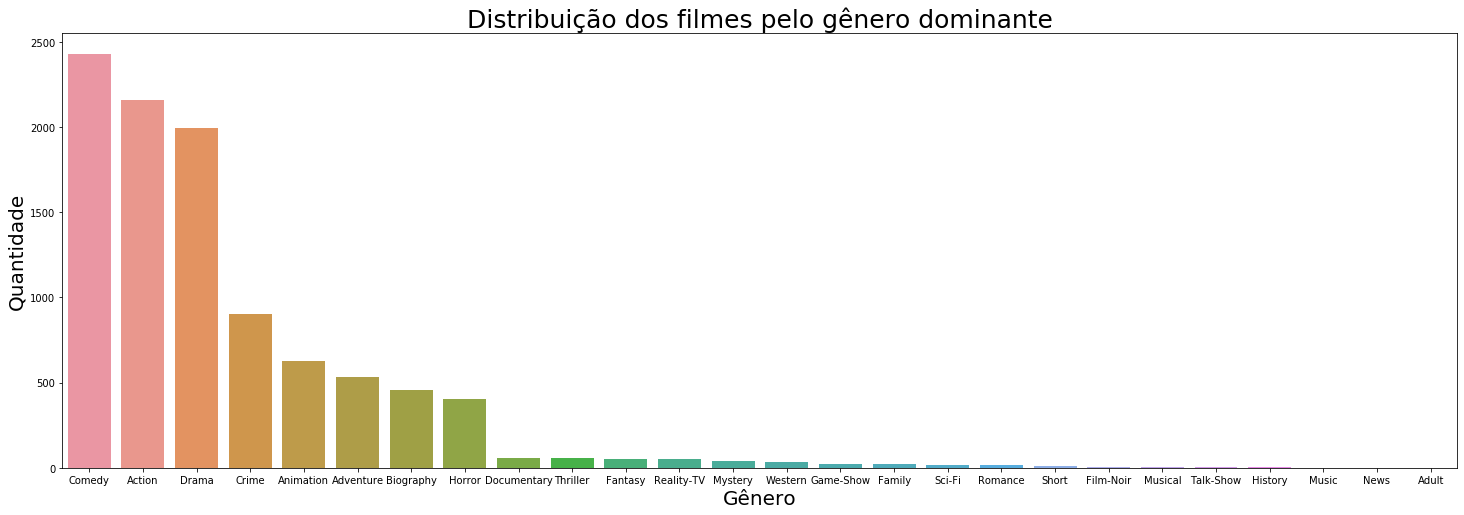

In [ ]:
dommoviegenre_dict = movies_df['dommoviegenre'].value_counts().to_dict()
keys_genre = list(dommoviegenre_dict.keys())
values_genre = list(dommoviegenre_dict.values())

ax = sns.barplot(keys_genre,values_genre)
plt.xlabel("Gênero", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
fig = plt.gcf()
fig.set_size_inches( 25, 8)
plt.savefig('genre.png')
plt.title("Distribuição dos filmes pelo gênero dominante", fontsize=25) 
plt.show();

### Criar dataframe com filmes organizados por gênero

In [ ]:
movies_genre = movies_df.copy()
movies_genre.set_index(['movietitle'], inplace=True)
groups = dict(tuple(movies_genre.groupby('dommoviegenre')))
df_grouped_genre = pd.concat(groups, axis=0, join='outer')
df_grouped_genre.drop('dommoviegenre', axis = 1, inplace=True)

In [ ]:
df_grouped_genre.head(10)

Out[61]:

movieruntime 
 movierating 
 moviescore 
 moviedescription 
 moviedirector 
 movievotes 
 moviestars 
 moviegenre 
 moviedate 
 moviefirstrun 
 moviegross 
 
 
 
 movietitle 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Action 
 Game of Thrones 
 57 
 9.3 
 NaN 
 Nine noble families fight for control over the... 
 NaN 
 1772519 
 Emilia Clarke, Peter Dinklage, Kit Harington, ... 
 Action, Adventure, Drama 
 2011 - 2019 
 2011 
 NaN 
 
 
 The Mandalorian 
 40 
 8.8 
 NaN 
 The travels of a lone bounty hunter in the out... 
 NaN 
 290530 
 Pedro Pascal, Gina Carano, Giancarlo Esposito,... 
 Action, Adventure, Sci-Fi 
 2019 
 2019 
 NaN 
 
 
 Vikings 
 44 
 8.5 
 NaN 
 Vikings transports us to the brutal and myster... 
 NaN 
 433338 
 Katheryn Winnick, Gustaf Skarsgård, Alexander ... 
 Action, Adventure, Drama 
 2013 - 2020 
 2013 
 NaN 
 
 
 News of the World 
 118 
 6.9 
 NaN 
 A Civil War veteran agrees to deliver a girl, ... 
 Paul Greengrass 
 31993 
 Tom Hanks, Helena Zengel, Tom Astor, Travis Jo... 
 Action, Adventure, Drama 
 2020 
 2020 
 NaN 
 
 
 Greenland 
 119 
 6.4 
 NaN 
 A family struggles for survival in the face of... 
 Ric Roman Waugh 
 60673 
 Gerard Butler, Morena Baccarin, Roger Dale Flo... 
 Action, Drama, Thriller 
 2020 
 2020 
 NaN 
 
 
 The Equalizer 
 NaN 
 4.2 
 NaN 
 An enigmatic figure who uses her extensive ski... 
 NaN 
 3497 
 Queen Latifah, Tory Kittles, Adam Goldberg, Li... 
 Action, Crime, Drama 
 2021 
 2021 
 NaN 
 
 
 Seungriho 
 136 
 6.6 
 NaN 
 Set in the year 2092 and follows the crew of a... 
 Sung-hee Jo 
 11222 
 Song Joong-Ki, Kim Tae-ri, Seon-kyu Jin, Hae-J... 
 Action, Adventure, Drama 
 2021 
 2021 
 NaN 
 
 
 Cobra Kai 
 30 
 8.6 
 NaN 
 Decades after their 1984 All Valley Karate Tou... 
 NaN 
 109266 
 Ralph Macchio, William Zabka, Xolo Maridueña, ... 
 Action, Comedy, Drama 
 2018 
 2018 
 NaN 
 
 
 Snowpiercer 
 60 
 6.8 
 NaN 
 Seven years after the world has become a froze... 
 NaN 
 27608 
 Daveed Diggs, Mickey Sumner, Alison Wright, Je... 
 Action, Drama, Sci-Fi 
 2020 
 2020 
 NaN 
 
 
 Lupin 
 231 
 7.6 
 NaN 
 Inspired by the adventures of Arsène Lupin, ge... 
 NaN 
 44304 
 Omar Sy, Vincent Londez, Ludivine Sagnier, Her... 
 Action, Crime, Drama 
 2021 
 2021 
 NaN

#### Salvar o dataframe em arquivo .csv

In [ ]:
compression_opts = dict(method='zip', archive_name='Moveis Clean Genre.csv')
df_grouped_genre.to_csv('Moveis Clean Genre.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 5 - Criar dataframe com filmes organizados por ano de lançamento

### Visualizar a distribuição dos filmes por ano de lançamento

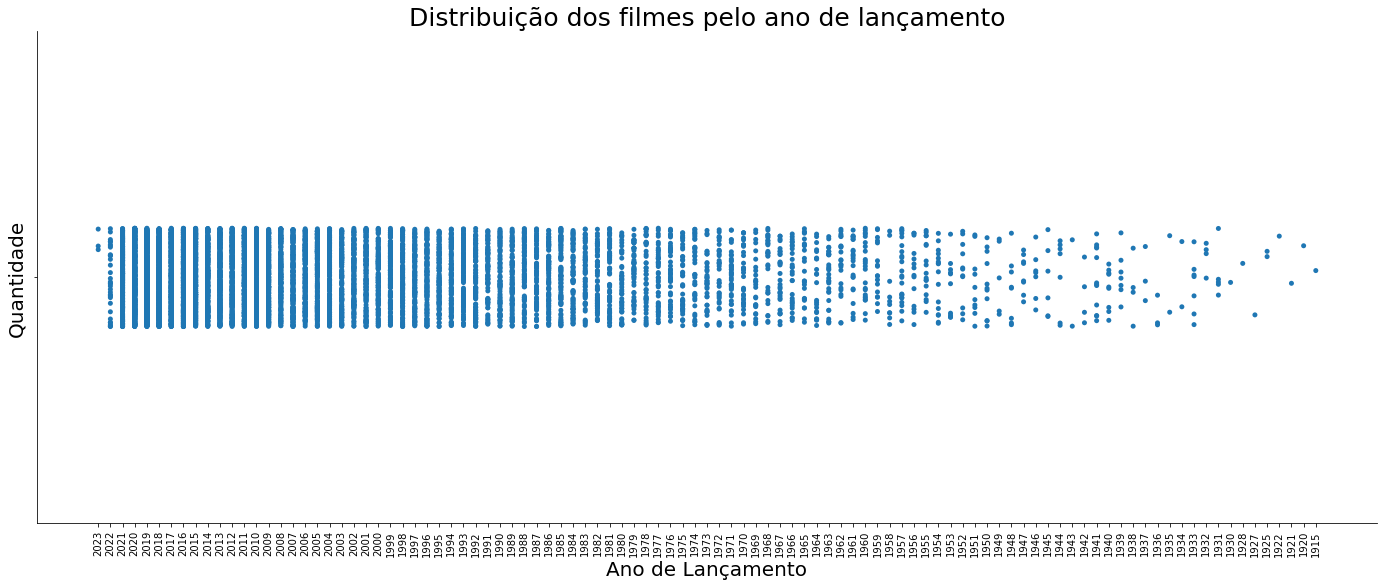

In [ ]:
movies_df_sorted = movies_df.sort_values(by=['moviefirstrun'],ascending=False)
ax = sns.catplot(data = movies_df_sorted, x = 'moviefirstrun')
plt.xlabel("Ano de Lançamento", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches( 20, 8)
plt.title("Distribuição dos filmes pelo ano de lançamento", fontsize=25) 
plt.savefig('date.png')
plt.show();

In [ ]:
movies_df_sorted.set_index(['movietitle'], inplace=True)
groups = dict(tuple(movies_df_sorted.groupby('moviefirstrun')))
df_grouped_date = pd.concat(groups, axis=0, join='outer')
df_grouped_date.drop('moviefirstrun', axis = 1, inplace=True)

In [ ]:
df_grouped_date.head(20)

Out[65]:

movieruntime 
 movierating 
 moviescore 
 moviedescription 
 moviedirector 
 movievotes 
 moviestars 
 moviegenre 
 dommoviegenre 
 moviedate 
 moviegross 
 
 
 
 movietitle 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1915 
 The Birth of a Nation 
 195 
 6.3 
 NaN 
 The Stoneman family finds its friendship with ... 
 D.W. Griffith 
 22838 
 Lillian Gish, Mae Marsh, Henry B. Walthall, Mi... 
 Drama, History, War 
 Drama 
 1915 
 1000000.0 
 
 
 1920 
 The Cabinet of Dr. Caligari 
 67 
 8.1 
 NaN 
 Hypnotist Dr. Caligari uses a somnambulist, Ce... 
 Robert Wiene 
 57632 
 Werner Krauss, Conrad Veidt, Friedrich Feher, ... 
 Fantasy, Horror, Mystery 
 Fantasy 
 1920 
 NaN 
 
 
 1921 
 The Kid 
 68 
 8.3 
 NaN 
 The Tramp cares for an abandoned child, but ev... 
 Charles Chaplin 
 113971 
 Charles Chaplin, Edna Purviance, Jackie Coogan... 
 Comedy, Drama, Family 
 Comedy 
 1921 
 545000.0 
 
 
 1922 
 Nosferatu 
 94 
 7.9 
 NaN 
 Vampire Count Orlok expresses interest in a ne... 
 F.W. Murnau 
 89052 
 Max Schreck, Alexander Granach, Gustav von Wan... 
 Fantasy, Horror 
 Fantasy 
 1922 
 NaN 
 
 
 1925 
 The Gold Rush 
 95 
 8.2 
 NaN 
 A prospector goes to the Klondike in search of... 
 Charles Chaplin 
 101538 
 Charles Chaplin, Mack Swain, Tom Murray, Henry... 
 Adventure, Comedy, Drama 
 Adventure 
 1925 
 545000.0 
 
 
 Battleship Potemkin 
 66 
 8.0 
 NaN 
 In the midst of the Russian Revolution of 1905... 
 Sergei M. Eisenstein 
 53276 
 Aleksandr Antonov, Vladimir Barskiy, Grigoriy ... 
 Drama, History, Thriller 
 Drama 
 1925 
 5000.0 
 
 
 1927 
 Metropolis 
 153 
 8.3 
 NaN 
 In a futuristic city sharply divided between t... 
 Fritz Lang 
 160599 
 Brigitte Helm, Alfred Abel, Gustav Fröhlich, R... 
 Drama, Sci-Fi 
 Drama 
 1927 
 124000.0 
 
 
 1928 
 The Passion of Joan of Arc 
 114 
 8.1 
 NaN 
 In 1431, Jeanne d'Arc is placed on trial on ch... 
 Carl Theodor Dreyer 
 48027 
 Maria Falconetti, Eugene Silvain, André Berley... 
 Biography, Drama, History 
 Biography 
 1928 
 2000.0 
 
 
 1930 
 All Quiet on the Western Front 
 152 
 8.0 
 NaN 
 A German youth eagerly enters World War I, but... 
 Lewis Milestone 
 57417 
 Lew Ayres, Louis Wolheim, John Wray, Arnold Lucy 
 Drama, War 
 Drama 
 1930 
 327000.0 
 
 
 1931 
 M 
 99 
 8.3 
 NaN 
 When the police in a German city are unable to... 
 Fritz Lang 
 144033 
 Peter Lorre, Ellen Widmann, Inge Landgut, Otto... 
 Crime, Mystery, Thriller 
 Crime 
 1931 
 3000.0 
 
 
 Dracula 
 75 
 7.5 
 NaN 
 After a naive real estate agent succumbs to th... 
 Tod Browning, Karl Freund 
 47025 
 Bela Lugosi, Helen Chandler, David Manners, Dw... 
 Drama, Fantasy, Horror 
 Drama 
 1931 
 NaN 
 
 
 City Lights 
 87 
 8.5 
 NaN 
 With the aid of a wealthy erratic tippler, a d... 
 Charles Chaplin 
 168531 
 Charles Chaplin, Virginia Cherrill, Florence L... 
 Comedy, Drama, Romance 
 Comedy 
 1931 
 2000.0 
 
 
 The Public Enemy 
 83 
 7.7 
 NaN 
 An Irish-American street punk tries to make it... 
 William A. Wellman 
 17947 
 James Cagney, Jean Harlow, Edward Woods, Joan ... 
 Crime, Drama 
 Crime 
 1931 
 NaN 
 
 
 Frankenstein 
 70 
 7.8 
 NaN 
 Dr. Frankenstein dares to tamper with life and... 
 James Whale 
 65529 
 Colin Clive, Mae Clarke, Boris Karloff, John B... 
 Drama, Horror, Sci-Fi 
 Drama 
 1931 
 NaN 
 
 
 1932 
 Man Wanted 
 62 
 6.5 
 NaN 
 A female editor of a magazine falls in love wi... 
 William Dieterle 
 598 
 Kay Francis, David Manners, Una Merkel, Andy D... 
 Romance, Comedy, Drama 
 Romance 
 1932 
 NaN 
 
 
 Beauty and the Boss 
 66 
 6.9 
 NaN 
 An executive hires a mousy, plain woman as his... 
 Roy Del Ruth 
 518 
 Marian Marsh, David Manners, Warren William, C... 
 Comedy, Romance 
 Comedy 
 1932 
 NaN 
 
 
 Freaks 
 64 
 7.9 
 NaN 
 A circus' beautiful trapeze artist agrees to m... 
 Tod Browning 
 42210 
 Wallace Ford, Leila Hyams, Olga Baclanova, Ros... 
 Drama, Horror 
 Drama 
 1932 
 NaN 
 
 
 Scarface 
 93 
 7.8 
 NaN 
 An ambitious and nearly insane violent gangste.

#### Salvar o dataframe em arquivo .csv

In [ ]:
compression_opts = dict(method='zip', archive_name='Moveis Clean Date.csv')
df_grouped_date.to_csv('Moveis Clean Date.zip', index=True, compression=compression_opts, encoding='windows-1252')